In [2]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

import os
import numpy as np
import random 

from torch.nn.parameter import Parameter

from qpth.qp import SpQPFunction, QPFunction
import cvxpy as cp

random.seed(7)

import matplotlib.pyplot as plt

In [3]:
input_params= pd.read_csv('../lcp_trails/data/4w_input_params.csv')
out_params=pd.read_csv('../lcp_trails/data/4w_out_params.csv')

In [4]:
input_params.head()

,x1,y1,vx1,vy1,x2,y2,vx2,vy2,x3,y3,vx3,vy3,x4,y4,vx4,vy4,x5,y5,vx5,vy5
0,76.892734,83.205377,48.895881,60.373413,79.337528,86.224048,48.895881,60.373413,81.782322,89.242719,48.895881,60.373413,84.227116,92.261389,48.895881,60.373413,86.671910,94.719940,48.895881,-60.373413
1,74.206161,79.102976,44.011201,52.914501,76.406721,81.748701,44.011201,52.914501,78.607281,84.394426,44.011201,52.914501,80.807841,87.040151,44.011201,52.914501,83.008401,89.685876,44.011201,52.914501
2,55.666011,69.666321,10.301838,35.756948,56.181103,71.454169,10.301838,35.756948,56.696195,73.242016,10.301838,35.756948,57.211287,75.029864,10.301838,35.756948,57.726379,76.817711,10.301838,35.756948
3,78.133180,76.006865,51.151237,47.285209,80.690742,78.371125,51.151237,47.285209,83.248304,80.735386,51.151237,47.285209,85.805866,83.099646,51.151237,47.285209,88.363428,85.463906,51.151237,47.285209
4,62.749660,83.862331,23.181200,61.567874,63.908720,86.940725,23.181200,61.567874,65.067780,90.019118,23.181200,61.567874,66.226840,93.097512,23.181200,61.567874,67.385900,93.824094,23.181200,-61.567874


In [5]:
out_params.head()

,x1,y1,vx1,vy1,x2,y2,vx2,vy2,x3,y3,vx3,vy3,x4,y4,vx4,vy4,x5,y5,vx5,vy5
0,39.763445,16.234503,-48.895881,-60.373413,37.318651,13.215832,-48.895881,-60.373413,34.873857,10.197161,-48.895881,-60.373413,32.429063,7.178491,-48.895881,-60.373413,29.984269,5.840180,-48.895881,60.373413
1,49.777037,31.525273,-44.011201,-52.914501,47.576477,28.879548,-44.011201,-52.914501,45.375917,26.233823,-44.011201,-52.914501,43.175357,23.588098,-44.011201,-52.914501,40.974797,20.942373,-44.011201,-52.914501
2,71.118769,66.698257,10.301838,-35.756948,71.633861,64.910409,10.301838,-35.756948,72.148953,63.122562,10.301838,-35.756948,72.664044,61.334714,10.301838,-35.756948,73.179136,59.546867,10.301838,-35.756948
3,35.139964,43.065322,-51.151237,-47.285209,32.582402,40.701062,-51.151237,-47.285209,30.024840,38.336802,-51.151237,-47.285209,27.467279,35.972541,-51.151237,-47.285209,24.909717,33.608281,-51.151237,-47.285209
4,92.478539,13.785858,-23.181200,-61.567874,91.319479,10.707464,-23.181200,-61.567874,90.160419,7.629070,-23.181200,-61.567874,89.001359,5.449323,-23.181200,61.567874,87.842299,8.527717,-23.181200,61.567874


In [6]:
data=input_params[['x1','y1','x2','y2','x3','y3','x4','y4','x5','y5']].values
target=out_params[['x1','y1','x2','y2','x3','y3','x4','y4','x5','y5']].values

In [7]:
data.shape

(10000, 10)

In [8]:
# return train,validation and test 
def data_loader(data,target):
    n,d=data.shape
    nTrain=int(0.8*n)
    nVal=int(0.1*n)
    nTest=n-nTrain-nVal
    train_data=data[0:nTrain]
    train_target=target[0:nTrain]

    val_data=data[nTrain:nTrain+nVal]
    val_target=target[nTrain:nTrain+nVal]

    test_data=data[nTrain+nVal:]
    test_target=target[nTrain+nVal:]

    return train_data, train_target, val_data, val_target, test_data, test_target



In [9]:
class simple_nn(nn.Module):
  
    def __init__(self,D_in,nHidd,D_out):
        super(simple_nn,self).__init__()
        self.fc1=nn.Linear(D_in,nHidd)
        self.fc2=nn.Linear(nHidd,nHidd)
        self.fc2=nn.Linear(nHidd,D_out)
        
    
    def forward(self,x):
        x=F.relu(self.fc1(x)) 
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
   

In [9]:
class OptNetEq(nn.Module):
    def __init__(self, nFeatures, nHidden, nCls, neq, Qpenalty=10, eps=1e-4):
        super().__init__()

        self.nFeatures = nFeatures
        self.nHidden = nHidden
        self.nCls = nCls

        self.fc1 = nn.Linear(nFeatures, nHidden)
        self.fc2 = nn.Linear(nHidden, nCls)

        self.Q = Variable(Qpenalty*torch.eye(nHidden).double()) # will not change 
#         GG=Variable(torch.zeros(nHidden).double()) 
#         GG[0:nHidden//2]=-0.5
#         GG=Variable(-torch.eye(nHidden).double())
#         GG[nHidden//2:nHidden-1,nHidden//2:nHidden-1]=-0
#         self.G=GG
        self.G = Parameter(-torch.eye(nHidden).double())
        self.h = Variable(torch.zeros(nHidden).double())
        self.A = Parameter(torch.rand(neq,nHidden).double()) # the only parameter 
        self.b = Variable(torch.ones(self.A.size(0)).double())

        self.neq = neq

    def forward(self, x):
        nBatch = x.size(0)

        # FC-ReLU-QP-FC-Softmax
        x = x.view(nBatch, -1)
        x = F.relu(self.fc1(x))

        Q = self.Q.unsqueeze(0).expand(nBatch, self.Q.size(0), self.Q.size(1))
        p = -x.view(nBatch,-1)
        G = self.G.unsqueeze(0).expand(nBatch, self.G.size(0), self.G.size(1))
        h = self.h.unsqueeze(0).expand(nBatch, self.h.size(0))
        A = self.A.unsqueeze(0).expand(nBatch, self.A.size(0), self.A.size(1))
        b = self.b.unsqueeze(0).expand(nBatch, self.b.size(0))

        x = QPFunction(verbose=False)(Q, p.double(), G, h, A, b).float()
        x = self.fc2(x)

        return x

In [10]:
def train_model(data,target,model,nepoch=30,batch_size=10):
 
    train_data, train_target, val_data, val_target, test_data, test_target=data_loader(data,target)

    nTrain = len(train_data)
    optimizer=optim.RMSprop(model.parameters(),lr=0.01)
    criterion=nn.MSELoss()

    test_data=Variable(torch.tensor(test_data))
    test_data=test_data.float()
    test_target=Variable(torch.tensor(test_target))
    test_target=test_target.float()

    for j in range(nepoch):
        err=0
        model.train()
        
        for i in range(1000):
            idx=np.random.randint(nTrain,size=batch_size)
            x=[]
            y=[]
            for k in range(10):
                x.append(torch.tensor(train_data[idx[k]]))
                y.append(torch.tensor(train_target[idx[k]]))
            
            x=torch.stack(x,dim=0)
            y=torch.stack(y,dim=0)

            X, Y = Variable(x,requires_grad=True),Variable(y)
            X=X.float()
            Y=Y.float()

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            

            err+=loss.data.tolist()
            loss.backward()
            optimizer.step()

        err=err/1000
        model.eval()
    
        test_pred=model(Variable(torch.tensor(test_data)))
        test_loss=criterion(test_pred,torch.tensor(test_target))

        print('epoch=%d/%d,train error=%f'%(j,nepoch,err))
        print('Train Loss:', loss.item())
        print('Test Loss:' ,test_loss.item())
    
    return output, X, Y

In [ ]:
# model=simple_nn(D_in=10,nHidd=100,D_out=10)
model=OptNetEq(nFeatures=10, nHidden=50, nCls=10, neq=10)
predict,init,true=train_model(data,target,model,nepoch=10,batch_size=10)

epoch=0/10,train error=764.087691
Train Loss: 1659.8922119140625
Test Loss: 676.6954345703125
epoch=1/10,train error=670.325198
Train Loss: 557.33349609375
Test Loss: 630.4758911132812


In [40]:
pred=predict.detach().numpy()
true=true.detach().numpy()
init=init.detach().numpy()

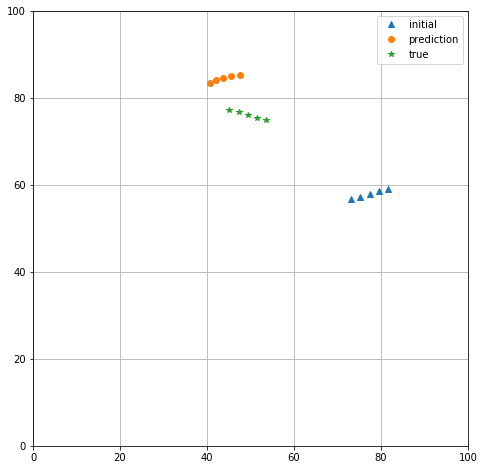

In [97]:
fig,ax=plt.subplots(figsize=(10,8))
i=1
ax.plot(init[i,0:10:2],init[i,1:10:2],'^',label='initial')
ax.plot(pred[i,0:10:2],pred[i,1:10:2],'o',label='prediction')
ax.plot(true[i,0:10:2],true[i,1:10:2],'*',label='true')

ax.axis('scaled')
ax.axis([0, 100, 0, 100])

ax.grid()

plt.legend()
plt.show()

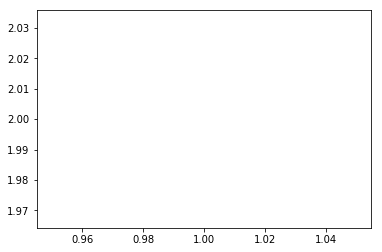

In [82]:
fig,ax=plt.subplots()
ax.set_xlim(left=0,right=100)
ax.set_ylim(bottom=0,top=100)
ax.plot([1,1],[2,2])
ax.axis('equal')
plt.show()

In [58]:
init[0]

array([65.12601 , 83.63592 , 66.5011  , 86.693726, 67.87619 , 89.75153 ,
       69.25129 , 92.80935 , 70.62638 , 94.13284 ], dtype=float32)